In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageOps
from PIL.ImageFilter import UnsharpMask
from PIL.ImageFilter import GaussianBlur
from PIL.ImageFilter import MedianFilter
import pandas as pd 
import os, sys

import seaborn as sns

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

%matplotlib inline
import cv2

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from keras.layers.core import Dropout, Activation

from sklearn.ensemble import RandomForestClassifier

from joblib import dump

C:\Users\tanne\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Validation 

Ce notebook à pour vocation de tester divers méthodes de preprocessing d'images. (On peut en outre citer l'égalisation et l'autocontraste, l'application de filtres gaussiens, médians, du sharpening ainsi que le ZCA whitening, proche du PCA whitening). Ces filtres ont souvent un ou plusieurs hyperparamètres (exemple rayon,intensité etc...) que l'on peut faire varier pour obtenir l'effet désiré. 
On applique ensuite l'algorithme SIFT dont l'objectif et d'obtenir des points clefs. Cet algorithme posséde lui aussi plusieurs hyperparamètres. Il applique plusieurs filtres gaussiens de variance gama sur un nombre choisi d'octaves (n_o), il calcule ensuite la différence entre chacune des images filtrées pour faire ressortir les caractéristiques propres à chaque différence d'octaves. Il sélectionne les caractéristiques dérirées via une valeur seuil.
Une fois les points clefs obtenus, on applique un algorithme de clustering (ici k-means) pour générer des "visuals words" correspondant aux caractéristiques d'images utilisées pour l'apprentissage supervisé. le nombre de cluster et donc le nombre de visual words est un autre hyperparamètre. 

De manière rigoureuse, on implémente une fonction dont l'objectif est d'appliquer ou non des actions de preprocessing (manipulation d'histogrammes, whitening ou applications de filtres) dans l'ordre choisi, puis de générer des points clefs grave à l'algorithme SIFT et enfin d'appliquer notre clustering pour déterminer des visuals words et étudier l'accuracie sur un jeu de validation. On peut faire varier chacun des hyperparamètres à notre guise et donc regarder quels jeux d'hyperparamètres maximisent l'accuracie. 

Normalement, l'application de tel ou tel procesus n'est pas indépendant des autres procesus, on devrait donc effectuer une validation sur grille en n dimensions (ou n représente le nombre d'hyperparamètres suceptibles de jouer un rôle dans la performance finale). 

Ce procesus étant très couteux en temps de calcul, nous effectuons plusieurs suppositions : 
Les visuals words correspondent (en première approximation) à des caractéristiques "physiques" des objets/chiens ex : oreille, oeuil etc... De ce fait, les hyperparamètres qui les générent (preprocessing et SIFT) ne doivent pas (ou peu) dépendre du nombre de classes. 

Ensuite, on calibre le nombre de cluster (visual words) sur le nombre de classe. Le nombre de cluster est donc le facteur d'un hyperparamètre avec le nombre de classes. Cela se base sur le fait que, plus le nombre de classes augmente, plus on a besoin de caractéristiques différentes pour déterminer chaque image (ex : différents types d'oreilles ou de poils).

On effectue donc la détermination des différents hyperparamètres du un nombre de classe restreint (dans ce notebook:10 classes)

On va ensuite considérer que le paramètre "nombre de visual words" est indépendant de la qualité des points clefs. On peut donc le tester indépendamment des autres paramètres. 

La valeur seuil a peu d'influence réelle sur la performance réelle (en dessous d'une certaine valeur) car elle ne fait qu'augmenter le nombre de points clefs détectés et, si ces points ne sont pas corrélés à la race du chien, dans ce cas ils seront considérés comme des outliders.
En revanche, elle influe grandement sur le temps de calcul. 

On peut en revanche considérer qu'il y a toujours une forte correlation entre les hyperparamètres de l'algorithme SIFT (variance et nombre d'octaves principalement) et la nature des filtres (combinaisons de filtres). Pour l'application de chaque procédés, on effectura donc une validation sur grille des paramètres (gama et o_c). Une fois la meilleure combinaison de filtres ainsi que le meilleur jeu de paramètres  gama et o_c, (c'est à dire le procédés qui maximise l'accuracie sur le jeu de validation), on déterminera le nombre de visual words le plus approprié. 

On effectue ici l'apprentissage supervisé via regression logistique et méthode one vs rest. On calcule à chaque fois l'accuracie pour différents paramètres de régularisation et on sélectionne la valeur du paramètre de régularisation qui maximise l'accuracie.


In [2]:
# initialiser les fonctions importantes 

def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    #print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)


def visualiser (X_train,nb_exemples,mixed):
    
    if (mixed == 1):    
        # mixed data do not print every time the same pictures    
        X_train = shuffle(X_train)
        
    # i breack
    i_b = 0    

    fig = plt.figure(1, figsize=(16, 16))

    grid = ImageGrid(fig, 111, nrows_ncols=(int(nb_exemples/4), int(nb_exemples/4)), axes_pad=0.1)
        
    for i in range (nb_exemples):       
        
        ax = grid[i_b]        
        
        ax.imshow(X_train[i,:,:,:] / 255.)        

        ax.axis('off')
                
        i_b = i_b + 1         


In [3]:
def visualiser_hist(X_train,nb_exemples,mixed):

    if (mixed == 1):    
       # mixed data do not print every time the same pictures    
       X_train = shuffle(X_train)
        
    # i breack
    i_b = 0    
    
    #plt.figure(1, figsize=(16, 16))

    fig, axs = plt.subplots(1, 1, figsize=(16, 7))
    
    plt.title("histogramme des exemples")
          
    for i in range (nb_exemples):       
        
               
        plt.hist(X_train[i,:,:,:].flatten(), bins=range(256), label='image n°{}'.format(i)) 
        
        plt.legend()
        
        axs.set_ylim(0, 3600)    
                        
        i_b = i_b + 1         


In [4]:
def ZCA_whitening(X_train,eps):
    """effectue un whitening via une ZCA objectif similaire au PCA whitening (hyperparamètre eps)"""
    
    # whitening pictures  

    X = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
    # se ramenner à l'interval [0,1]
    X = 1./255 * X

    # enlever la moyenne pixel par pixel 
    X_norm = X - np.mean(X,axis=0)

    cov = np.cov(X_norm, rowvar=True)

    U,S,V = np.linalg.svd(cov)

    # epsilon est le coef de la ZCA     
    epsilon = eps

    # on résoud l'équation matricielle 
    X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_norm)

    X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())

    X_train = X_ZCA_rescaled.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])

    X_train = X_train*255

    return (X_train)


In [5]:
# application de l'algorithme SIFT (librairie CV2)

def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def gen_sift_features(gray_img,o_L,c_T,e_T,sigma):
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=0,nOctaveLayers=o_L,contrastThreshold=c_T,
                                  edgeThreshold=e_T,sigma=sigma)
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    
        
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [6]:
def visualiser2(X_train,nb_exemples,mixed,o_L,c_T,e_T,sigma):
    
    if (mixed == 1):    
        # mixed data do not print every time the same pictures    
        X_train = shuffle(X_train)
        
    # i breack
    i_b = 0  
    
    fig, axarr = plt.subplots(int(nb_exemples/4), int(nb_exemples/4), figsize=(16,16),sharex=True)
        
    j = 0   
    j2 = 0
    for i in range (nb_exemples):        
        
        if (j == int(nb_exemples/4)):
            
            j = 0 
            j2 = j2 + 1
        
               
        img_gray = to_gray(color_img=X_train[i,:,:,:].astype(np.uint8))
        
        
        kp, desc = gen_sift_features(img_gray,o_L=o_L,c_T=c_T,e_T=e_T,sigma=sigma)
       
        axarr[j,j2].imshow(cv2.drawKeypoints(img_gray, kp, X_train[i,:,:,:].astype(np.uint8).copy()))  
        
        axarr[j,j2].axis('off')  
        
                
        j = j + 1  
        
        
def special_points(X_train,o_L,c_T,e_T,sigma): 
    
    dim = 0
    for i in range (X_train.shape[0]):    

        # image grise (8 bits)               
        img_gray = to_gray(color_img=X_train[i,:,:,:].astype(np.uint8))

        # trouver les points spéciaux (SIFT) 
        kp, desc = gen_sift_features(img_gray,o_L=o_L,c_T=c_T,e_T=e_T,sigma=sigma)
        
        #print (desc)

        dim = dim + desc.shape[0]


    # liste des points spéciaux 
    special = np.zeros((dim,128))

    # vecteur d'indice 
    indice = np.zeros(dim)

    j = 0    
    for i in range (X_train.shape[0]):    

        # image grise (8 bits)               
        img_gray = to_gray(color_img=X_train[i,:,:,:].astype(np.uint8))

        # trouver les points spéciaux (SIFT) 
        kp, desc = gen_sift_features(img_gray,o_L=o_L,c_T=c_T,e_T=e_T,sigma=sigma) 
        
        #print (desc)

        for d in range (desc.shape[0]):
            # ajouter le point
            special[j,:] = desc[d]

            indice[j] = i

            j = j + 1   
            
    return (indice,special)        
        
        

In [7]:
def acc_heatmap(predictions,y_test,nb_classes):
    
    list_predict = []
    list_test = []

    for i in range (predictions.shape[0]):
        
        list_predict.append(np.argmax(predictions[i,:]))
        list_test.append(np.argmax(y_test[i,:]))


    d = {'predict': list_predict, 'test': list_test}
    df = pd.DataFrame(data=d)

    valeurs = plot_value_counts('test',df=df)
    print (valeurs.shape)
    print (nb_classes)


    heat_matrix = np.zeros((nb_classes,nb_classes))


    for i in range (valeurs.shape[0]):
        for j in range (valeurs.shape[0]):

            heat_matrix[i,j] = df[(df.iloc[:,0] == float(valeurs.iloc[i,0])) & (df.iloc[:,1] == float(valeurs.iloc[j,0]))].shape[0] / float(valeurs.iloc[j,1])

            

    return (heat_matrix)


def performance_best(liste_name,heatmap,nb):
    """retourne la liste des nb meilleures performances (race/race) ainsi que la liste des accuracies"""
    perf_name = []
    perf_element = []    
    
    for i in range (heatmap.shape[0]):
        
        perf_element.append(heatmap[i,i])
        perf_name.append(liste_name[i])
        
    d = {'name': perf_name[:], 'acc': perf_element[:]}
    df = pd.DataFrame(data=d)
    
    df = df.sort_values(by=['acc'], ascending=[False])
    
    a = heatmap.copy()
    for i in range (heatmap.shape[0]):        
         
        # on ne tient pas compte des éléments sur la diagonale
        a[i,i] = 0
        
    liste_predict, liste_test, value = [], [], []
    for i in range (nb):        
               
        z = (np.argmax(a) + 1) / a.shape[0]
        #print (z)

        if ((np.argmax(a)+1)%(a.shape[0]) == 0):

            ordd = int(z) - 1
            abss = a.shape[0] - 1

        else : 

            ordd = int(z)
            abss = (np.argmax(a)+1)%(a.shape[0]) - 1 
            
        liste_predict.append(liste_name[ordd])        
        liste_test.append(liste_name[abss])
        
        value.append(a[ordd,abss])
            
        a[ordd,abss] = 0 
        
    d = {'predict': liste_predict[:], 'test': liste_test[:], 'fp':value[:]}
    df2 = pd.DataFrame(data=d) 
    
    df2 = df2.sort_values(by=['fp'], ascending=[False])
    
    
    return (df,df2)

In [8]:
# compter et ouvrir les fichiers 

# Open a file
path = "./Images"
dirs = os.listdir( path )

liste_name = []
liste_number = [] 

# This would print all the files and directories
for file in dirs:
    
    liste_name.append(str(file))
    path2 = "./Images/" + str(file)
    dirs2 = os.listdir( path2 )
    
    n = 0
    for pictures in dirs2:
        n = n + 1 
    liste_number.append(n)

In [11]:
# ouvrir les fichiers 

# Open a file
path = "./Images"
dirs = os.listdir( path )

# list picture name 
picture = []
# list breed 
breed = []

# This would print all the files and directories
j = 0

i = 0

for file in (dirs):
    
    if (i > 9):
            
            break  # otherwise the generator would loop indefinitely
    
                
    i = i + 1
    
    
    path2 = "./Images/" + str(file)
    dirs2 = os.listdir( path2 )
    
       
    # compter les itérations
    i_t = 0  
    
        
    for file2 in dirs2:       
               
              
        train_n = int(np.around( 0.60 * len(dirs2)))
        valid_n = int(np.around(0.80 * len(dirs2)))        
        
        breed.append(str(file))
        picture.append(str(file2))
        
        
        i_t = i_t + 1
        
        file_picture = path2 + '/' + str(file2)        
        
        
        if (i_t <= train_n):            
                    
            img = load_img(file_picture)  # this is a PIL image  
            
            img.save("./images_t/tr/"  + str(file2) ) 
                    
        if (i_t > train_n) and (i_t <= valid_n):
            
            img = load_img(file_picture)  # this is a PIL image
            
            img.save("./images_t/te/"  + str(file2) ) 
            
        if (i_t > valid_n):
            
            img = load_img(file_picture)  # this is a PIL image
            
            img.save("./images_t/valid/"  + str(file2) )
            
        if i_t > (np.around(len(dirs2))):
            
                break  # otherwise the generator would loop indefinitely
                

                
d = {'picture_name': picture[:], 'breed': breed[:]}
labels = pd.DataFrame(data=d)

labels.to_csv('labels.csv')

In [9]:
# Open a file
path = "./images_t/tr/"
dirs = os.listdir( path )

nb_train = len(dirs)

# Open a file
path = "./images_t/te/"
dirs = os.listdir( path )

nb_test = len(dirs)

# Open a file
path = "./images_t/valid/"
dirs = os.listdir( path )

nb_valid = len(dirs)
    
print (nb_train, nb_test, nb_valid)

1150 386 383


In [11]:
valeurs = plot_value_counts('breed',df=labels)

liste_name = valeurs.iloc[:,0]

In [12]:
print (liste_name.shape)

(10,)


In [10]:
# PARAMS 

# nombre de classes (races de chiens)
nb_classes = 10  #120
dim_Xception = 299
dim_vgg19 = 300


# ouvrir le fichier 

labels = pd.read_csv('labels.csv')

In [13]:
X_train0 = np.zeros((nb_train,dim_vgg19,dim_vgg19,3),dtype=np.float32)

y_train0 = np.zeros((nb_train,nb_classes),dtype='uint32')

In [14]:
X_test0 = np.zeros((nb_test,dim_vgg19,dim_vgg19,3),dtype=np.float32)

y_test0 = np.zeros((nb_test,nb_classes),dtype='uint32')

In [15]:
X_valid0 = np.zeros((nb_valid,dim_vgg19,dim_vgg19,3),dtype=np.float32)

y_valid0 = np.zeros((nb_valid,nb_classes),dtype='uint32')

In [16]:
j_valid = 0

# Open a file
path = "./images_t/valid/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g')     
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_valid0[j_valid,:] = label_binarize([class_name], classes=liste_name)
    #print (y_valid[j_valid,:])
        
    file_picture = "./images_t/valid/" + str(file)
     
    img = Image.open(file_picture)
    img.thumbnail((300, 300))
    
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_valid0[j_valid,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_valid = j_valid + 1

In [17]:
j_train = 0

# Open a file
path = "./images_t/tr/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g') 
    
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_train0[j_train,:] = label_binarize([class_name], classes=liste_name)
    #print (y_train[j_train,:])
        
    file_picture =  "./images_t/tr/" + str(file)
    
    img = Image.open(file_picture)
    img.thumbnail((300, 300))
        
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_train0[j_train,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_train = j_train + 1

In [18]:
j_te = 0

# Open a file
path = "./images_t/te/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g')    
    
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_test0[j_te,:] = label_binarize([class_name], classes=liste_name)
    #print (y_train[j_train,:])
        
    file_picture =  "./images_t/te/" + str(file)
    
    img = Image.open(file_picture)
    img.thumbnail((300, 300))
        
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_test0[j_te,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_te = j_te + 1

In [21]:
def test_models(X_train=X_train0,y_train=y_train0,X_valid=X_valid0,y_valid=y_valid0,nb_classes=nb_classes,
               sharp=True,r=2,p=150,t=3,autocontrast=True,equalize=True,Gaussian_r=(-1),median=3,zca_eps=0.001,nb_cluster_ratio=10,
               o_L=3,c_T=0.04,e_T=10,sigma=1.6,
               random_forest=False,
               nn_network=False,
               logistic=True):
    
    # Procédure : identifier la pertinence des points caractéristiques détectés :     
    
    # ---- 1 
    # on fixe la valeur e_T (seuil), le nombre de clusters 
    # on fait varier les caractéristiques o_L, sigma et les caractéristiques des masques
    # a) autocontrast + equalize + masque gaussien + sift (varier o_L, sigma) + clustering + appliquer classification (max reg)
    # b) autocontrast + equalise + masque median + sift (varier o_L, sigma) + clustering + appliquer classification (max reg)
    # c) appliquer zca_whitening + sift (varier o_L, sigma) + clustering + appliquer classification (max reg)
    # d) autocontrast + equalise + masque median + zca_whitening + sift (varier o_L, sigma)
    
    # ---- 2
    # au augmente le nombre de clusters sur le meilleur modèle
    # on baisse le seuil (on augmente le nombre de points caractéristiques) sur le meilleur modèle  
    
    # ---- 3
    # on test différents modèles de classification
    
    # ---- 4
    # augmenter le nombre de classes 
       
    
    score = []
    
    # no gaussian filter if r = 0
    # no zca whitening if zca_eps = 0
    # nb_cluster = nb_cluster_ratio * nb_classes
    
    #  ---------------- SIFT --------------
    # o_L > number of layers in each octave
    # c_T > contrast threshold 
    # e_T > threshold used to filter out edge-like features
    # sigma > gaussian argument
    
    
    # --------------------------------- Filters application ------------------------------------
    
    # appliquer l'autocontrast    
    if (autocontrast == True):
        print ('step1 ---- done ')
        
                
        for i in range (X_train.shape[0]):
    
            img = array_to_img(X_train[i,:,:,:])
            img2 = ImageOps.autocontrast(img, cutoff=0, ignore=None)
            img3 = img_to_array(img2)

            X_train[i,:,:,:] = img3[:,:,:]
            
        for i in range (X_valid.shape[0]):
    
            img = array_to_img(X_valid[i,:,:,:])
            img2 = ImageOps.autocontrast(img, cutoff=0, ignore=None)
            img3 = img_to_array(img2)

            X_valid[i,:,:,:] = img3[:,:,:] 
            
    # égaliser l'histogramme           
    if (equalize == True):
        print ('step2 ---- done ')
        
        for i in range (X_train.shape[0]):
    
            img = array_to_img(X_train[i,:,:,:])
            img2 = ImageOps.equalize(img)
            img3 = img_to_array(img2)

            X_train[i,:,:,:] = img3[:,:,:]
            
        for i in range (X_valid.shape[0]):
    
            img = array_to_img(X_valid[i,:,:,:])
            img2 = ImageOps.equalize(img)
            img3 = img_to_array(img2)

            X_valid[i,:,:,:] = img3[:,:,:] 
    
         
        
    # sharpened 
    if (sharp == True):
        print ('sharping')
        
        for i in range (X_train.shape[0]):
            
                
            img = array_to_img(X_train[i,:,:,:])
            img2 = img.filter(UnsharpMask(radius=r, percent=p, threshold=t))
            img3 = img_to_array(img2)

            X_train[i,:,:,:] = img3[:,:,:]
            
        for i in range (X_valid.shape[0]):
            
                
            img = array_to_img(X_valid[i,:,:,:])
            img2 = img.filter(UnsharpMask(radius=r, percent=p, threshold=t))
            img3 = img_to_array(img2)

            X_valid[i,:,:,:] = img3[:,:,:] 
    
    
            
    # appliquer masque gaussien de rayon "Gaussian_r"            
    if (Gaussian_r > 0): 
        print ('step gaussian filter > done ')
        
        for i in range (X_train.shape[0]):
    
            img = array_to_img(X_train[i,:,:,:])
            img2 = img.filter(GaussianBlur(radius=Gaussian_r))
            img3 = img_to_array(img2)

            X_train[i,:,:,:] = img3[:,:,:]
            
        for i in range (X_valid.shape[0]):
    
            img = array_to_img(X_valid[i,:,:,:])
            img2 = img.filter(GaussianBlur(radius=Gaussian_r))
            img3 = img_to_array(img2)

            X_valid[i,:,:,:] = img3[:,:,:]
            
    # appliquer le filtre median            
    if (median > 0): 
        print ('step median filter > done')
        
        for i in range (X_train.shape[0]):
    
            img = array_to_img(X_train[i,:,:,:])
            img2 = img.filter(MedianFilter(size=median))
            img3 = img_to_array(img2)

            X_train[i,:,:,:] = img3[:,:,:]
            
        for i in range (X_valid.shape[0]):
    
            img = array_to_img(X_valid[i,:,:,:])
            img2 = img.filter(MedianFilter(size=median))
            img3 = img_to_array(img2)

            X_valid[i,:,:,:] = img3[:,:,:]
            
    
    # appliquer ZCA whitening 
    if (zca_eps > 0):
        print ('step3 ---- done ')
        
        X_zca = X_train.copy()
        X_zca_valid = X_valid.copy()
            
        X_train = ZCA_whitening(X_train=X_zca,eps=zca_eps)

        X_valid = ZCA_whitening(X_train=X_zca_valid,eps=zca_eps)
        
    # mixed = 1 pour générer aléatoirement
    visualiser(X_train=X_train,nb_exemples=16,mixed=0)         
        
    
        
    # ------------------------------------ SIFT -------------------------------    
   
    
    indice, special = special_points(X_train=X_train,o_L=o_L,c_T=c_T,e_T=e_T,sigma=sigma)[:]
    
    
    
    print ('step4 ---- done ')
    print (special.shape)
    
    indice_valid, special_valid = special_points(X_train=X_valid,o_L=o_L,c_T=c_T,e_T=e_T,sigma=sigma)[:]
    
    # standardiser les données 
    sdt = StandardScaler()
    X_sdt = sdt.fit_transform(special)
    
    # appliquer k_means 

    nb_cluster = nb_classes * nb_cluster_ratio

    sub_data = (X_sdt[0:40000,:])
    
    kmeans = KMeans(n_clusters=nb_cluster,init='k-means++',random_state=0).fit(shuffle(sub_data))
    
    kmeans.transform(sub_data)
    
    labels_groups = kmeans.predict(X_sdt)
    
    print ('step5 ---- done ')

 
    d = {'indice': indice[:].tolist(), 'cluster': labels_groups[:]}
    labels = pd.DataFrame(data=d)
    
    
    # créer les histogrammes pour chaque image (features de la classification)
    hist = np.zeros((X_train.shape[0],nb_cluster))

    for j in range (X_train.shape[0]):    

        df = labels[labels.iloc[:,0] == j]
        val = plot_value_counts(col_name='cluster',df=df)

        val = val.sort_values(by=['cluster'])

        for i in range (val.shape[0]):

            hist[j,int(val.iloc[i,0])] = np.asarray(val.iloc[i,1]) 
            
            
    # calculer X_valid en utilisant k_nn (ou kmeans_predict)

    # standardiser les données 
    sdt = StandardScaler()
    X_sdt_valid = sdt.fit_transform(special_valid)

    label_valid = kmeans.predict(X_sdt_valid)

    d = {'indice': indice_valid[:].tolist(), 'cluster': label_valid[:]}
    labels_valid = pd.DataFrame(data=d)

    # créer les histogrammes pour chaque image (features de la classification)

    hist_valid = np.zeros((X_valid.shape[0],nb_cluster))


    for j in range (X_valid.shape[0]):    

        df = labels_valid[labels_valid.iloc[:,0] == j]
        val = plot_value_counts(col_name='cluster',df=df)

        val = val.sort_values(by=['cluster'])

        for i in range (val.shape[0]):

            hist_valid[j,int(val.iloc[i,0])] = np.asarray(val.iloc[i,1]) 
            
            
    if (logistic == True): 
        print ('step7 >>>>>> done ')
            
        accuracy = []
        
        # reg param (C)

        reg = [0.001,0.01,0.1,1,10,100,500,1000]

        for r in (reg):

            # créer un modèle de regression logistique 

            clf = LogisticRegression(C=r)

            # utiliser one vs rest pour résoudre    

            ovc = OneVsRestClassifier(estimator=clf).fit(hist,y_train) 

            dump(ovc, 'model_full2.joblib') 

            y_predict = ovc.predict_proba(hist_valid)


            # on selectionne grace à l'accuracy

            acc = 0

            for i in range (y_predict.shape[0]):
                if (np.argmax(y_predict[i,:]) == np.argmax(y_valid[i,:])):
                    acc = acc + 1


            acc = acc / y_predict.shape[0]

            accuracy.append(acc)
            
                
    if (random_forest == True):
        
        accuracy = [] 
        
        clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
        
         # utiliser one vs rest pour résoudre    

        ovc = OneVsRestClassifier(estimator=clf).fit(hist,y_train) 

        dump(ovc, 'model_full2.joblib') 
        
        y_predict = ovc.predict_proba(hist_valid)
        
        # on selectionne grace à l'accuracy       

        acc = 0

        for i in range (y_predict.shape[0]):
            if (np.argmax(y_predict[i,:]) == np.argmax(y_valid[i,:])):
                acc = acc + 1


        acc = acc / y_predict.shape[0]

        accuracy.append(acc)
        
    if (nn_network == True):
        
        accuracy = []   
        
        # create the model    
        
        model = Sequential()

        model.add(Dense(1000, input_shape=(hist.shape[1],),activation='relu'))

        #model.add(Dropout(tronq[k]))

        model.add(Dense(y_train.shape[1], activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

        print(model.summary())

        model.fit(hist, y_train, validation=[hist_valid,y_valid], epochs=10, batch_size=40)
        
        y_predict = model.predict(hist_valid)
        
        # on selectionne grace à l'accuracy

        acc = 0

        for i in range (y_predict.shape[0]):
            if (np.argmax(y_predict[i,:]) == np.argmax(y_valid[i,:])):
                acc = acc + 1


        acc = acc / y_predict.shape[0]

        accuracy.append(acc)
        
    accuracy_vect = np.asarray(accuracy)
    
    return (np.amax(accuracy_vect), reg[int(np.argmax(accuracy_vect))])
    
    
    
    

# On applique aucun filtre

step4 ---- done 
(299855, 128)
step5 ---- done 
step7 >>>>>> done 
0.2193211488250653
0.001
step4 ---- done 
(109772, 128)
step5 ---- done 
step7 >>>>>> done 
0.27154046997389036
0.01
step4 ---- done 
(71857, 128)
step5 ---- done 
step7 >>>>>> done 
0.26109660574412535
0.001
step4 ---- done 
(54850, 128)
step5 ---- done 
step7 >>>>>> done 
0.27154046997389036
0.001


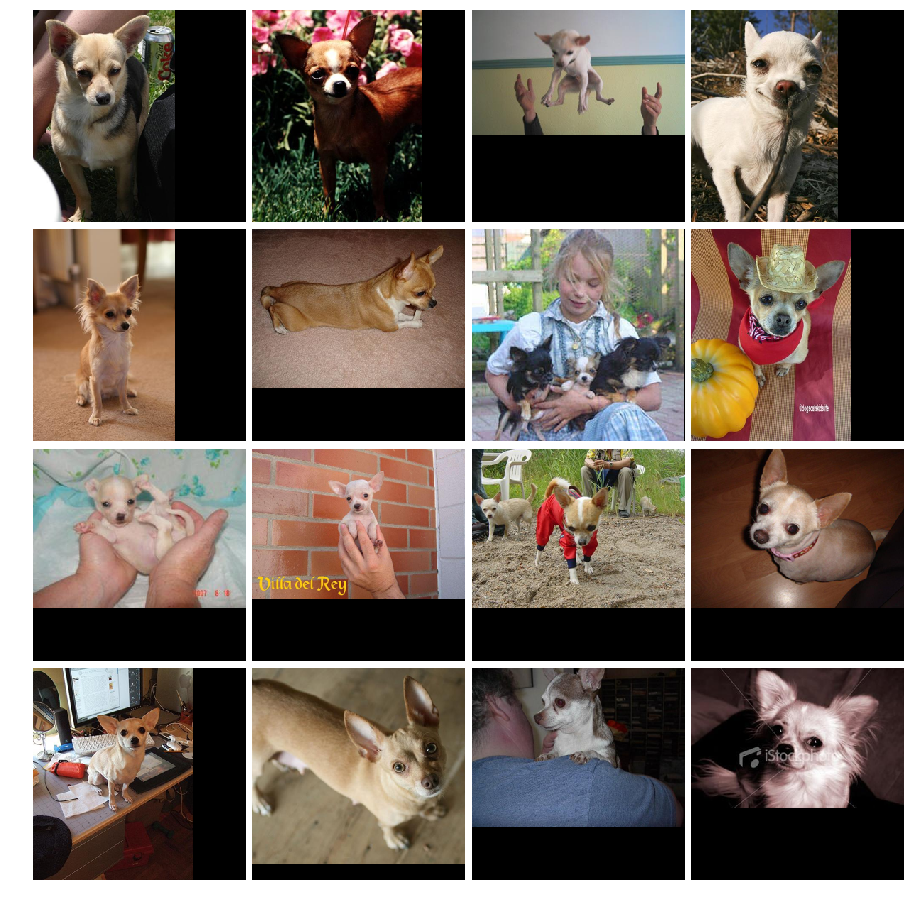

In [23]:
#sharp + median + sift 

ol = [3,4,5,6]
sigma = [1,2,3,4]

acc_heatmap = np.zeros((len(ol),len(sigma)))
reg_heatmap = np.zeros((len(ol),len(sigma)))

for i in range(len(ol)):
    for j in range(len(sigma)):
        
        acc, reg = test_models(X_train=X_train0.copy(),y_train=y_train0.copy(),X_valid=X_valid0.copy(),y_valid=y_valid0.copy(),
               nb_classes=nb_classes,
               sharp=False,r=4,p=570,t=4,autocontrast=False,equalize=False,Gaussian_r=(-1),median=(-1),zca_eps=(-1),nb_cluster_ratio=10,
               o_L=ol[i],c_T=0.1,e_T=10,sigma=sigma[j],
               random_forest=False,
               nn_network=False,
               logistic=True)
        
        acc_heatmap[i,j] = acc
        print (acc)
        reg_heatmap[i,j] = np.log(reg)
        print (reg)

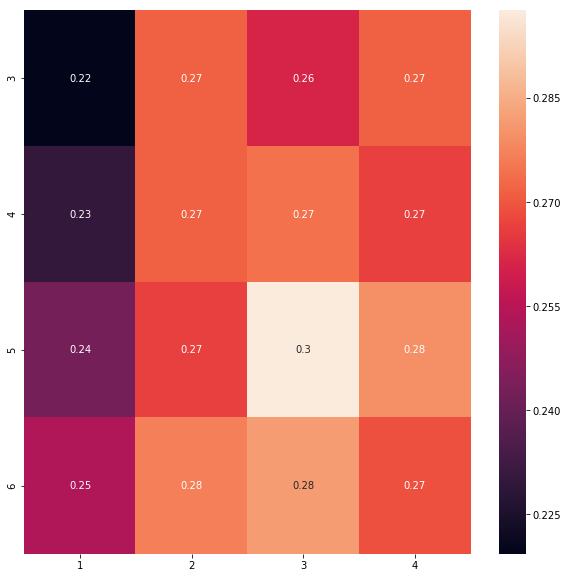

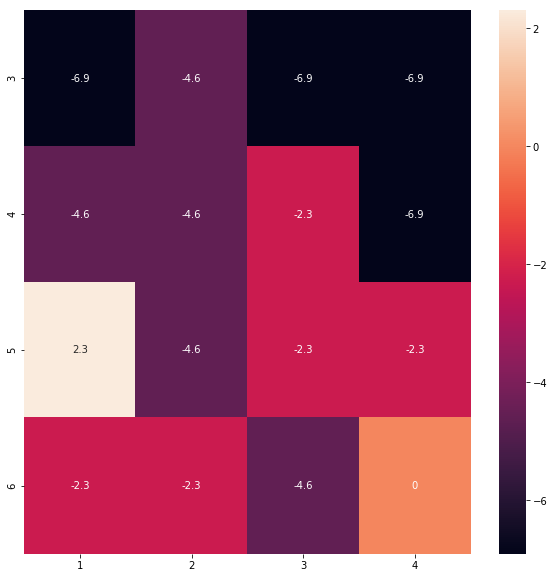

In [33]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(acc_heatmap3,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodel1.png')

plt.figure(figsize=(10,10))

ax = sns.heatmap(reg_heatmap3,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodelr1.png')

# On applique un filtre gaussien (r=3)

step gaussian filter > done 
step4 ---- done 
(132476, 128)
step5 ---- done 
step7 >>>>>> done 
0.25326370757180156
0.1
step gaussian filter > done 
step4 ---- done 
(153151, 128)
step5 ---- done 
step7 >>>>>> done 
0.2454308093994778
100
step gaussian filter > done 
step4 ---- done 
(159063, 128)
step5 ---- done 
step7 >>>>>> done 
0.24281984334203655
0.01
step gaussian filter > done 
step4 ---- done 
(156566, 128)
step5 ---- done 
step7 >>>>>> done 
0.2193211488250653
10
step gaussian filter > done 
step4 ---- done 
(140483, 128)
step5 ---- done 
step7 >>>>>> done 
0.21409921671018275
0.1
step gaussian filter > done 
step4 ---- done 
(154246, 128)
step5 ---- done 
step7 >>>>>> done 
0.2193211488250653
0.01
step gaussian filter > done 
step4 ---- done 
(158835, 128)
step5 ---- done 
step7 >>>>>> done 
0.2349869451697128
0.01
step gaussian filter > done 
step4 ---- done 
(158844, 128)
step5 ---- done 
step7 >>>>>> done 
0.21148825065274152
0.001
step gaussian filter > done 
step4 ---- 

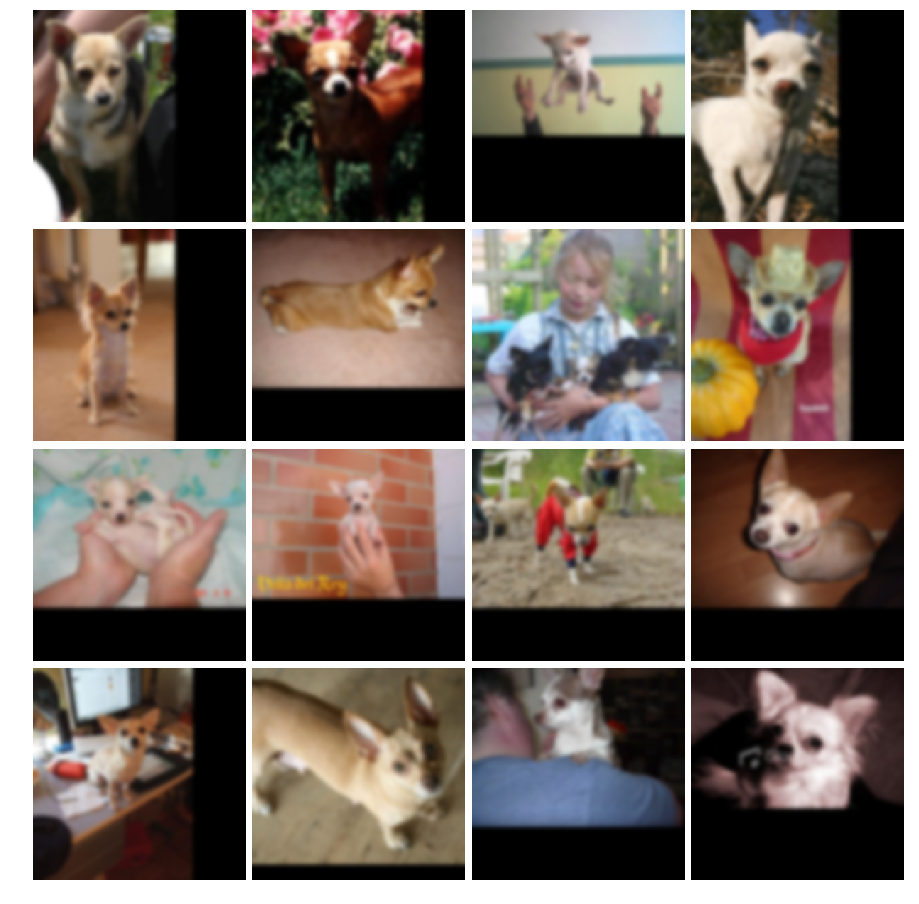

In [35]:
#sharp + median + sift 

ol = [3,4,5,6]
sigma = [1,2,3,4]

acc_heatmap = np.zeros((len(ol),len(sigma)))
reg_heatmap = np.zeros((len(ol),len(sigma)))

for i in range(len(ol)):
    for j in range(len(sigma)):
        
        acc, reg = test_models(X_train=X_train0.copy(),y_train=y_train0.copy(),X_valid=X_valid0.copy(),y_valid=y_valid0.copy(),
               nb_classes=nb_classes,
               sharp=False,r=4,p=570,t=4,autocontrast=False,equalize=False,Gaussian_r=(3),median=(-1),zca_eps=(-1),nb_cluster_ratio=10,
               o_L=ol[i],c_T=0.01,e_T=10,sigma=sigma[j],
               random_forest=False,
               nn_network=False,
               logistic=True)
        
        acc_heatmap[i,j] = acc
        print (acc)
        reg_heatmap[i,j] = np.log(reg)
        print (reg)

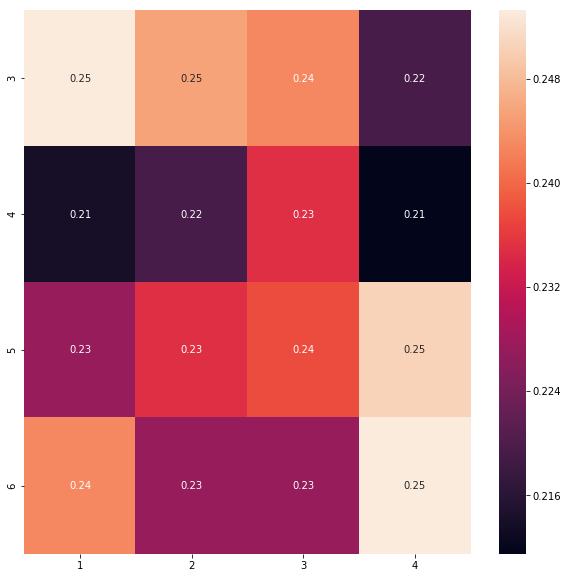

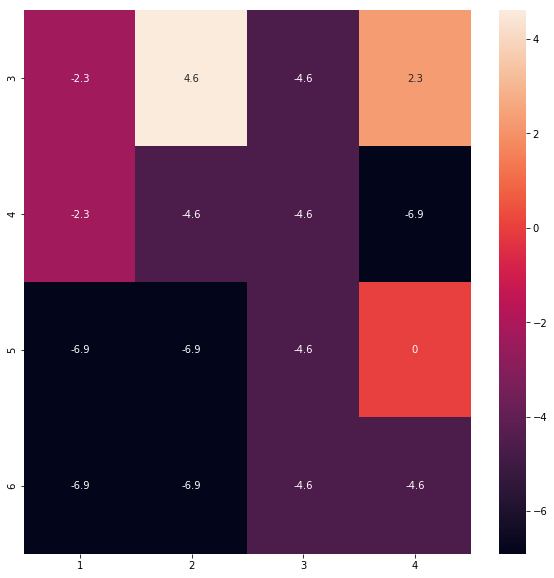

In [36]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(acc_heatmap,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodel1.png')

plt.figure(figsize=(10,10))

ax = sns.heatmap(reg_heatmap,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodelr1.png')

les performances du filtre gaussien sont moins bonnes que lorsque l'on applique aucun filtre. Cela doit s'expliquer par le fait que les images fournies ne sont pas (ou peu) bruitées et qu'elles ne comportent pas (ou peu) de pixels morts. Le filtre gaussien n'a donc pour incidence que de flouter l'image et de faire disparaitre des détails possiblement significatifs

# On applique l'égalisation des histogrammes et l'auto-contraste

step1 ---- done 
step2 ---- done 
step4 ---- done 
(336668, 128)
step5 ---- done 
step7 >>>>>> done 
0.185378590078329
0.001
step1 ---- done 
step2 ---- done 
step4 ---- done 
(420264, 128)
step5 ---- done 
step7 >>>>>> done 
0.2010443864229765
0.001
step1 ---- done 
step2 ---- done 
step4 ---- done 
(237517, 128)
step5 ---- done 
step7 >>>>>> done 
0.2689295039164491
0.01
step1 ---- done 
step2 ---- done 
step4 ---- done 
(278095, 128)
step5 ---- done 
step7 >>>>>> done 
0.2584856396866841
0.01
step1 ---- done 
step2 ---- done 
step4 ---- done 
(561991, 128)
step5 ---- done 
step7 >>>>>> done 
0.185378590078329
0.001
step1 ---- done 
step2 ---- done 
step4 ---- done 
(575609, 128)
step5 ---- done 
step7 >>>>>> done 
0.195822454308094
1
step1 ---- done 
step2 ---- done 
step4 ---- done 
(290889, 128)
step5 ---- done 
step7 >>>>>> done 
0.2193211488250653
0.001
step1 ---- done 
step2 ---- done 
step4 ---- done 
(335254, 128)
step5 ---- done 
step7 >>>>>> done 
0.2506527415143603
0.001
s

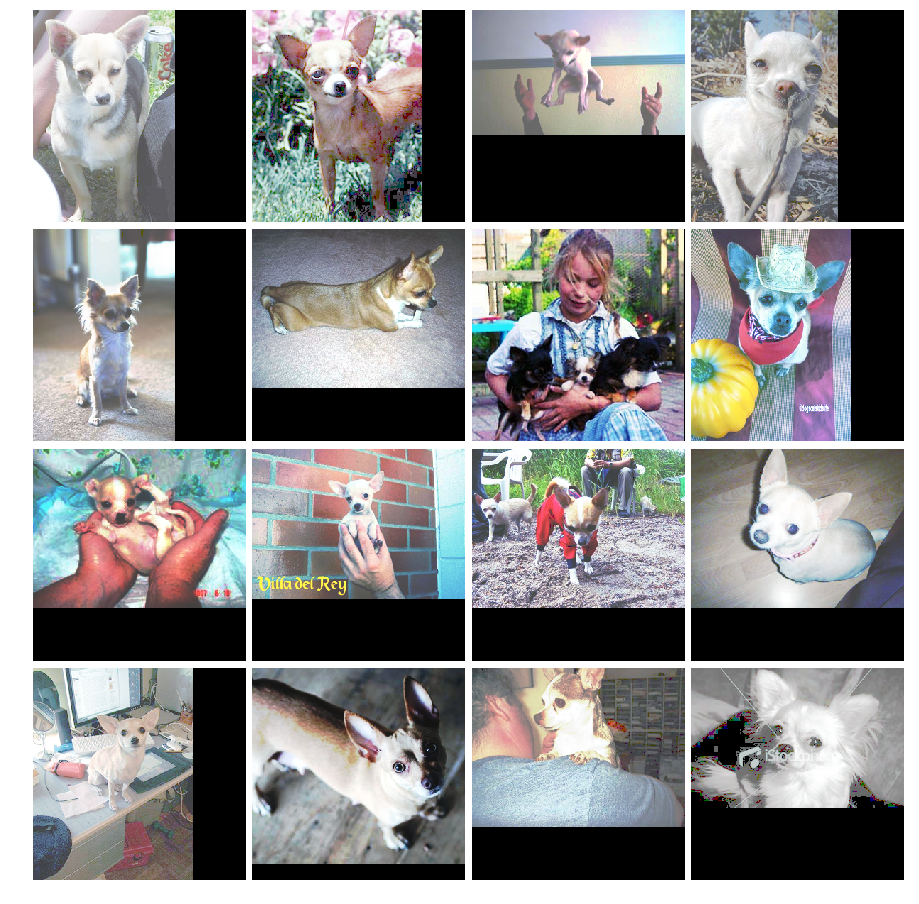

In [24]:
#sharp + median + sift 

ol = [2,3,4,5]
sigma = [0.5,1,2,2.5]
c_T = [0.12,0.09,0.06,0.03]

acc_heatmap = np.zeros((len(ol),len(sigma)))
reg_heatmap = np.zeros((len(ol),len(sigma)))

for i in range(len(ol)):
    for j in range(len(sigma)):
        
        acc, reg = test_models(X_train=X_train0.copy(),y_train=y_train0.copy(),X_valid=X_valid0.copy(),y_valid=y_valid0.copy(),
               nb_classes=nb_classes,
               sharp=False,r=4,p=570,t=4,autocontrast=True,equalize=True,Gaussian_r=(-1),median=(-1),zca_eps=(-1),nb_cluster_ratio=10,
               o_L=ol[i],c_T=c_T[j],e_T=10,sigma=sigma[j],
               random_forest=False,
               nn_network=False,
               logistic=True)
        
        acc_heatmap[i,j] = acc
        print (acc)
        reg_heatmap[i,j] = np.log(reg)
        print (reg)

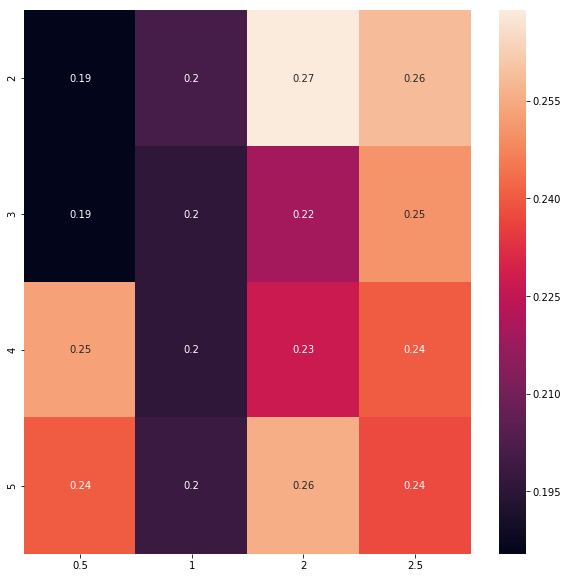

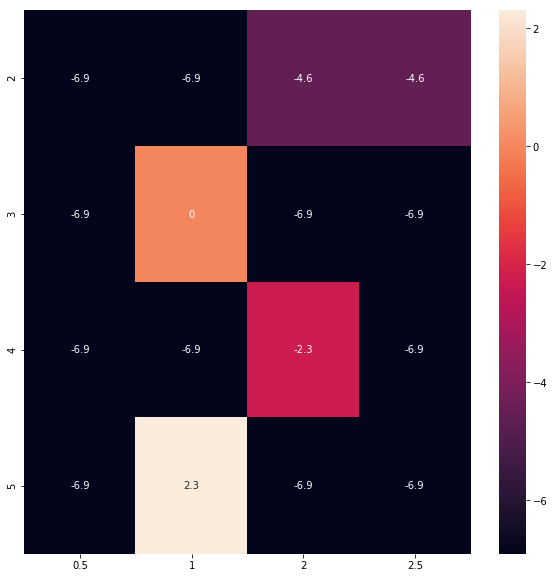

In [25]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(acc_heatmap,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodel1.png')

plt.figure(figsize=(10,10))

ax = sns.heatmap(reg_heatmap,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodelr1.png')

L'égalisation des histogrammes et l'auto-contraste ne donne pas de résultats meilleurs. Cela doit s'expliquer par le fait que la luminosité et le contraste des images originales mettent déjà relativement bien l'objet (le chien) en valeur.

# Appliquer le sharpening (r=4 p=360 t=4)

sharping
step4 ---- done 
(570197, 128)
step5 ---- done 
step7 >>>>>> done 
0.2558746736292428
0.001
sharping
step4 ---- done 
(191363, 128)
step5 ---- done 
step7 >>>>>> done 
0.30809399477806787
0.01
sharping
step4 ---- done 
(98723, 128)
step5 ---- done 
step7 >>>>>> done 
0.2741514360313316
1
sharping
step4 ---- done 
(55128, 128)
step5 ---- done 
step7 >>>>>> done 
0.2689295039164491
0.001


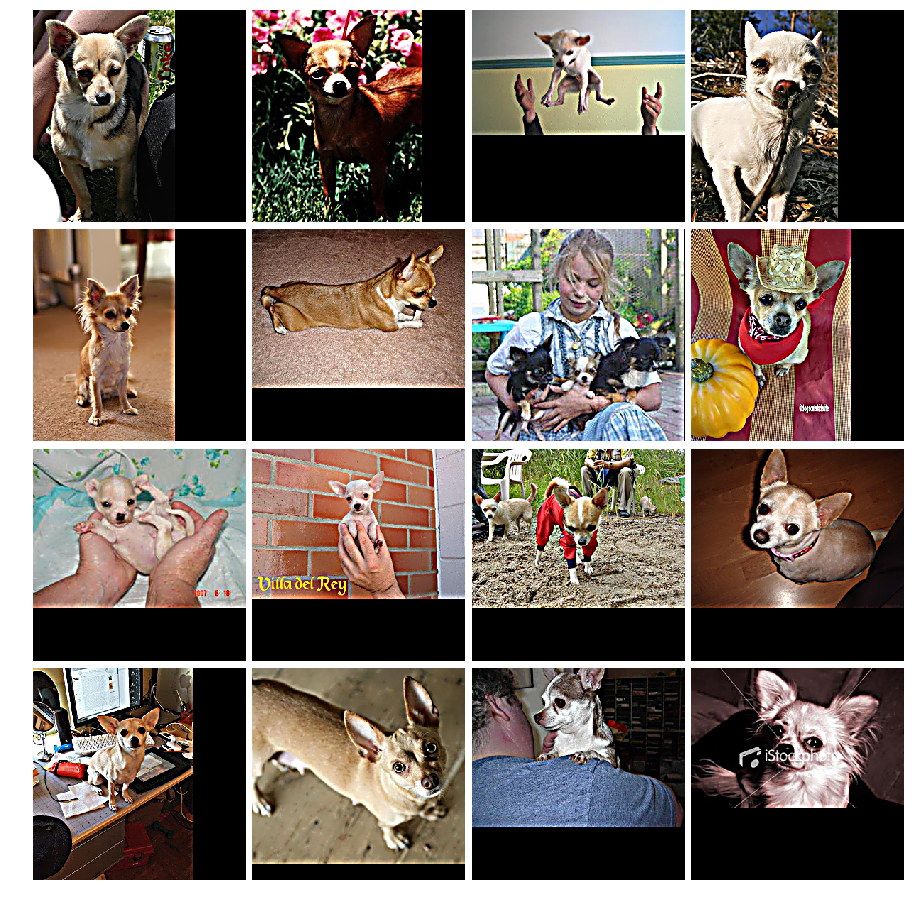

In [20]:
#sharp + median + sift 

ol = [2,3,4,5]
sigma = [1,2,3,4]

acc_heatmap2 = np.zeros((len(ol),len(sigma)))
reg_heatmap2 = np.zeros((len(ol),len(sigma)))

for i in range(len(ol)):
    for j in range(len(sigma)):
        
        acc, reg = test_models(X_train=X_train0.copy(),y_train=y_train0.copy(),X_valid=X_valid0.copy(),y_valid=y_valid0.copy(),
               nb_classes=nb_classes,
               sharp=True,r=4,p=190,t=4,autocontrast=False,equalize=False,Gaussian_r=(-1),median=(-1),zca_eps=(-1),nb_cluster_ratio=10,
               o_L=ol[i],c_T=0.16,e_T=10,sigma=sigma[j],
               random_forest=False,
               nn_network=False,
               logistic=True)
        
        acc_heatmap2[i,j] = acc
        print (acc)
        reg_heatmap2[i,j] = np.log(reg)
        print (reg)

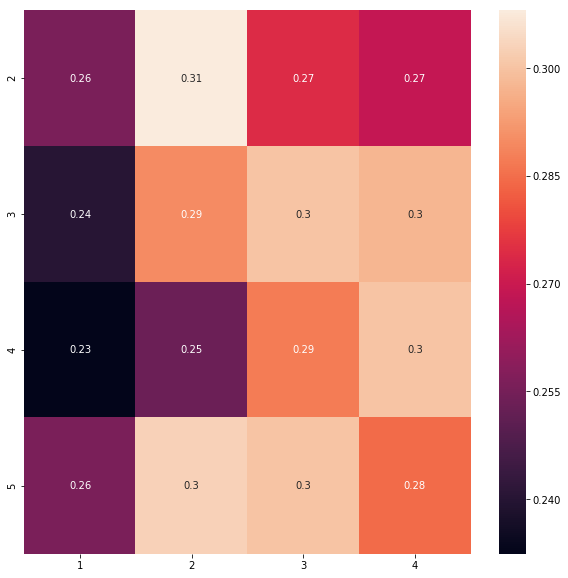

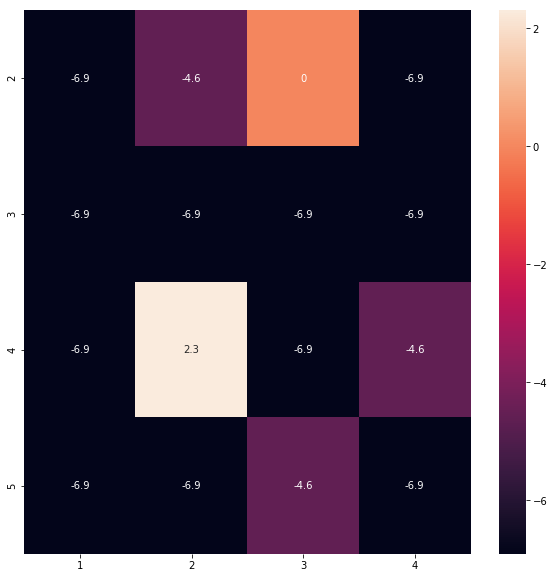

In [28]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(acc_heatmap3,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodel1.png')

plt.figure(figsize=(10,10))

ax = sns.heatmap(reg_heatmap3,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodelr1.png')

sharping
step median filter > done
step4 ---- done 
(481739, 128)
step5 ---- done 
step7 >>>>>> done 
0.2193211488250653
0.001
sharping
step median filter > done
step4 ---- done 
(275361, 128)
step5 ---- done 
step7 >>>>>> done 
0.26109660574412535
0.001
sharping
step median filter > done
step4 ---- done 
(145776, 128)
step5 ---- done 
step7 >>>>>> done 
0.21671018276762402
0.001
sharping
step median filter > done
step4 ---- done 
(78908, 128)
step5 ---- done 
step7 >>>>>> done 
0.2402088772845953
0.01
sharping
step median filter > done
step4 ---- done 
(692118, 128)
step5 ---- done 
step7 >>>>>> done 
0.2193211488250653
1
sharping
step median filter > done
step4 ---- done 
(291906, 128)
step5 ---- done 
step7 >>>>>> done 
0.2584856396866841
0.1
sharping
step median filter > done
step4 ---- done 
(157177, 128)
step5 ---- done 
step7 >>>>>> done 
0.25326370757180156
0.001
sharping
step median filter > done
step4 ---- done 
(86982, 128)
step5 ---- done 
step7 >>>>>> done 
0.2454308093994

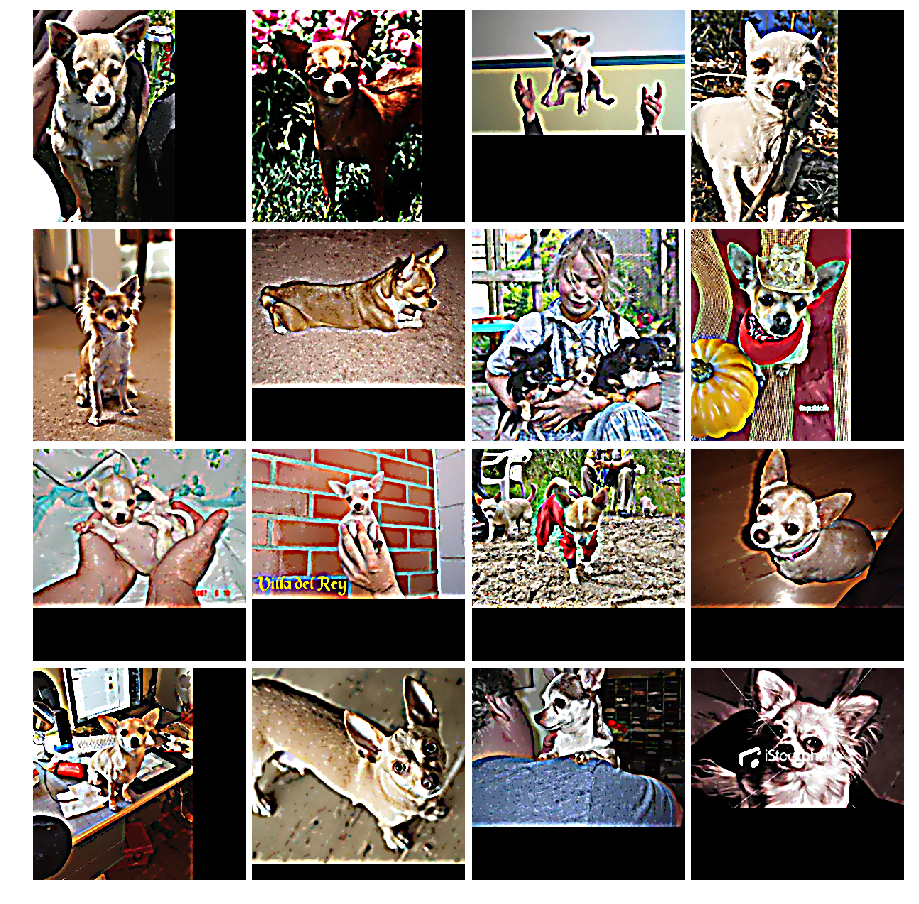

In [21]:
#sharp + median + sift 

ol = [4,5]
sigma = [1,2,3,4]

acc_heatmap2 = np.zeros((len(ol),len(sigma)))
reg_heatmap2 = np.zeros((len(ol),len(sigma)))

for i in range(len(ol)):
    for j in range(len(sigma)):
        
        acc, reg = test_models(X_train=X_train0.copy(),y_train=y_train0.copy(),X_valid=X_valid0.copy(),y_valid=y_valid0.copy(),
               nb_classes=nb_classes,
               sharp=True,r=4,p=680,t=4,autocontrast=False,equalize=False,Gaussian_r=(-1),median=(3),zca_eps=(-1),nb_cluster_ratio=10,
               o_L=ol[i],c_T=0.26,e_T=10,sigma=sigma[j],
               random_forest=False,
               nn_network=False,
               logistic=True)
        
        acc_heatmap2[i,j] = acc
        print (acc)
        reg_heatmap2[i,j] = np.log(reg)
        print (reg)

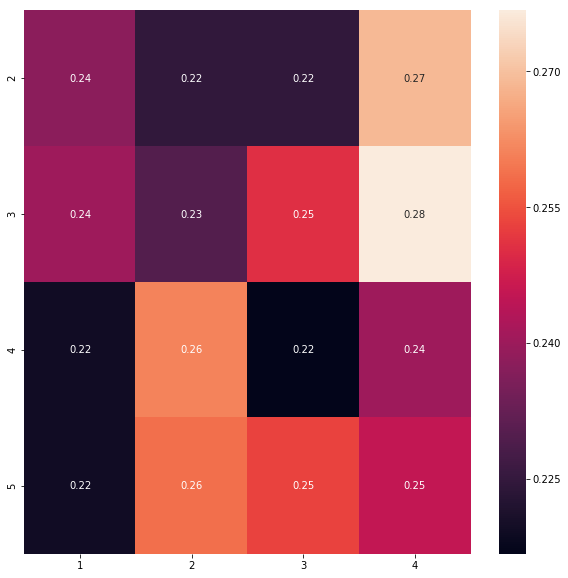

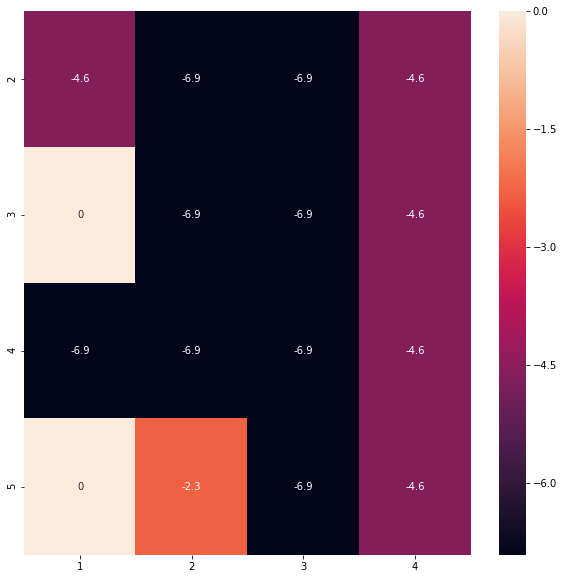

In [27]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(acc_heatmap3,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodel1.png')

plt.figure(figsize=(10,10))

ax = sns.heatmap(reg_heatmap3,annot=True,xticklabels=sigma[:],yticklabels=ol[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodelr1.png')

la présence du sharpening donne des résultats significativement meilleurs. Le sharpening renforce les contours et permet donc une meilleure identification des points caractéristiques du chien. On doit trouver un juste milieu car trop de sharpening aboutie à une présence de bruits et à un effacement des détails. 

# Détermination du nombre de cluster optimal

On considère le pré-processing ainsi que l'ensemble de paramètres qui maximisaient l'accuracy dans le travail précédent.
A savoir, du sharpening (r=4, p=360, t=4), ol =  sigma= e_t=  et on fait varier le nombre de clusters (visuals words).
Les accuracies sont toujours déterminées à l'optimum de régularisation.

sharping
step4 ---- done 
(375773, 128)
step5 ---- done 
step7 >>>>>> done 
0.3237597911227154
0.001
sharping
step4 ---- done 
(375773, 128)
step5 ---- done 
step7 >>>>>> done 
0.32114882506527415
0.001
sharping
step4 ---- done 
(375773, 128)
step5 ---- done 
step7 >>>>>> done 
0.2898172323759791
0.001
sharping
step4 ---- done 
(375773, 128)
step5 ---- done 
step7 >>>>>> done 
0.2950391644908616
0.001


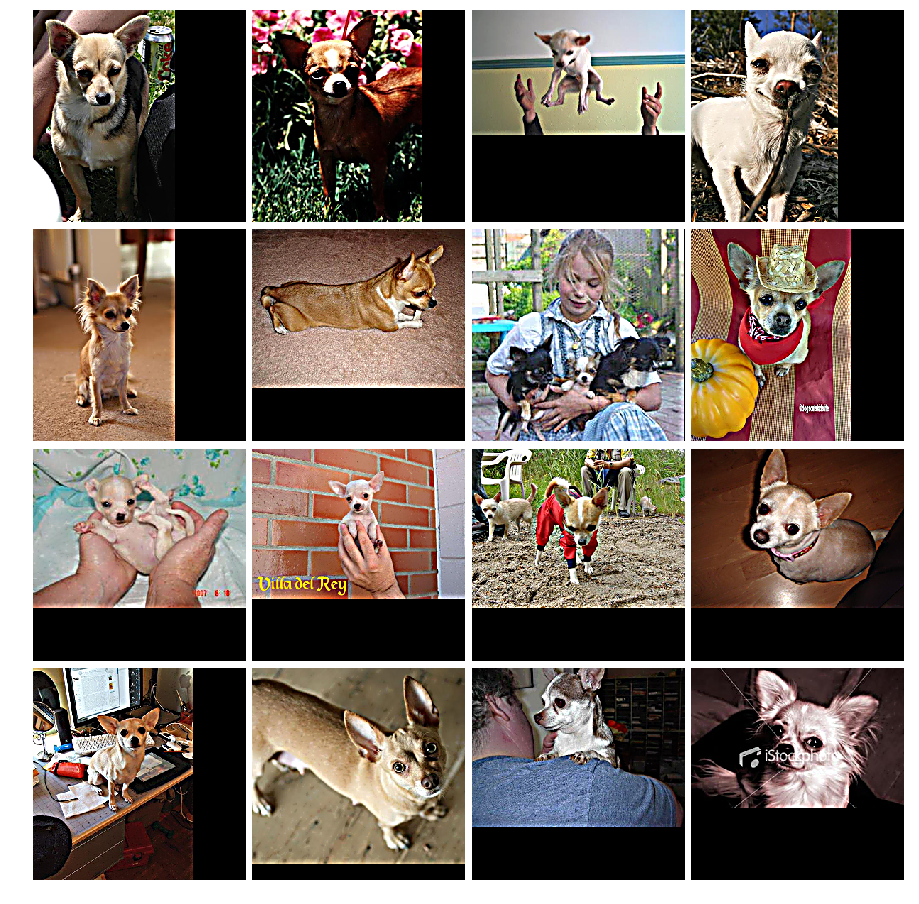

In [20]:
# sharp + filtre median + sift 

cluster = [15,20,25,30]
sigma = [2]

acc_heatmap = np.zeros((len(cluster),len(sigma)))
reg_heatmap = np.zeros((len(cluster),len(sigma)))

for i in range(len(cluster)):
    for j in range(len(sigma)):
        
        acc, reg = test_models(X_train=X_train0.copy(),y_train=y_train0.copy(),X_valid=X_valid0.copy(),y_valid=y_valid0.copy(),
               nb_classes=nb_classes,
               sharp=True,r=4,p=180,t=4,autocontrast=False,equalize=False,Gaussian_r=(-1),median=(-1),zca_eps=(-1),nb_cluster_ratio=cluster[i],
               o_L=2,c_T=0.08,e_T=10,sigma=sigma[j],
               random_forest=False,
               nn_network=False,
               logistic=True)
        
        acc_heatmap[i,j] = acc
        print (acc)
        reg_heatmap[i,j] = np.log(reg)
        print (reg)

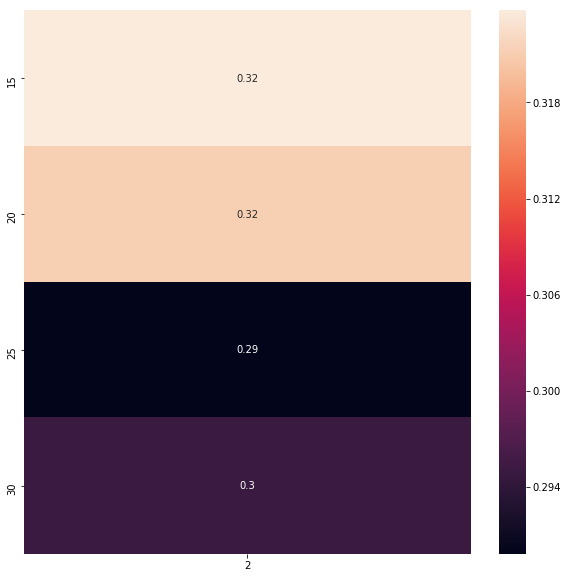

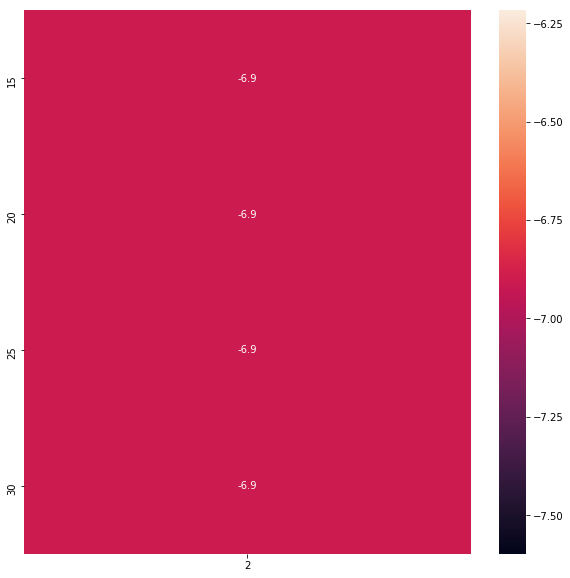

In [22]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(acc_heatmap,annot=True,xticklabels=sigma[:],yticklabels=cluster[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodel1.png')

plt.figure(figsize=(10,10))

ax = sns.heatmap(reg_heatmap,annot=True,xticklabels=sigma[:],yticklabels=cluster[:])

ax.axes.get_xaxis().set_visible(True)

plt.savefig('heatmap_tesmodelr1.png')